<a href="https://colab.research.google.com/github/romanzes637/functional_python/blob/master/compose_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from functools import reduce
from functools import partial

def compose(fs, *argv, **kwargs):
  return reduce(lambda x, y: y(*x[0], **x[1]), fs, (argv, kwargs))

# Agents

In [0]:
import random

def gradient(func, args, values, path, *argv, **kwargs):
  dx = kwargs.setdefault('dx', 1)
  prev_v = values[-1] if len(values) > 0 else func(*args[0], **args[1])
  new_v = prev_v
  new_p = args
  for i, arg in enumerate(args[0]):
    for sign in [1, -1]:
      new_argv = [x for x in args[0]]
      new_argv[i] += sign * dx
      v = func(*new_argv, **args[1])
      if v < new_v:
        new_v = v
        new_p = [new_argv, args[1]]
  for k in args[1]:
    for sign in [1, -1]:
      new_kwargs = {k: v for k, v in args[1].items()}
      new_kwargs[k] += sign * dx
      v = func(*new_argv, **args[1])
      if v < new_v:
        new_v = v
        new_p = [args[0], new_kwargs]
  values.append(new_v)
  path.append(new_p)
  return (func, new_p, values, path, *argv), kwargs
  
def tunnel(func, args, values, path, *argv, **kwargs):
  d = kwargs.setdefault('d', 1)
  delta = random.uniform(0, d)
  new_argv = [x + random.uniform(-delta, delta) for x in args[0]]
  new_kwargs = {k: v + random.uniform(-delta, delta) for k, v in args[1].items()}
  prev_v = values[-1] if len(values) > 0 else func(*args[0], **args[1])
  new_v = func(*new_argv, **new_kwargs)
  if new_v < prev_v:
    args = [new_argv, new_kwargs]
    values.append(new_v)
  else:
    values.append(prev_v)
  path.append(args)
  return (func, args, values, path, *argv), kwargs

def limit(func, args, values, path, *argv, **kwargs):
  vl = kwargs.setdefault('vl', [[-1, 1] for _ in args[0]])
  kwl = kwargs.setdefault('kwl', [[-1, 1] for _ in args[1]])
  new_p = None
  if len(path) > 0:  # get last allowed position
    for j in range(len(path) - 1, -1, -1):
      found = True
      p = path[j]
      for i, arg in enumerate(p[0]):
        if arg < vl[i][0] or arg > vl[i][1]:
          found = False
          break
      for arg in enumerate(p[1].values()):
        if arg < kwl[i][0] or arg > kwl[i][1]:
          found = False
          break
      if found:
        new_p = p
        new_v = values[j]
        break
  if new_p is None:  # reset position
    new_p = args
    for i, arg in enumerate(args[0]):
      args[0][i] = random.uniform(vl[i][0], vl[i][1])
    for k in args[1]:
      args[1][k] = random.uniform(kwl[i][0], kwl[i][1])
    new_v = func(*args[0], **args[1])
  values.append(new_v)
  path.append(new_p)
  return (func, new_p, values, path, *argv), kwargs

# Compositions
gt = partial(compose, [gradient, tunnel])
gtl = partial(compose, [gradient, tunnel, limit])
gggtl = partial(compose, [gradient, gradient, gradient, tunnel, limit])

# Test functions

In [0]:
import numpy as np

def himmelblau(x, y):  # -5 x 5
  return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def auckley(x, y):  # -5 x 5
  return -20*np.e*(-0.2*(0.5*(x**2 + y**2))**0.5) - np.e**(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + np.e + 20
  
def schaffer_2(x, y):  # -100 x 100
  return 0.5 + (np.sin(x**2 - y**2)**2 - 0.5) * (1 + 0.001*(x**2 + y**2))**-2

def eggholder(x, y):  # -512 x 512
  return -(y + 47)*np.sin((abs(0.5*x + y + 47))**0.5) - x*np.sin((abs(x - y + 47))**0.5)

def holder_table(x, y):  # -10 x 10
  return -abs(np.sin(x)*np.cos(y)*np.e**(abs(1 - (x**2 + y**2)**0.5*np.pi**-1)))

# Test

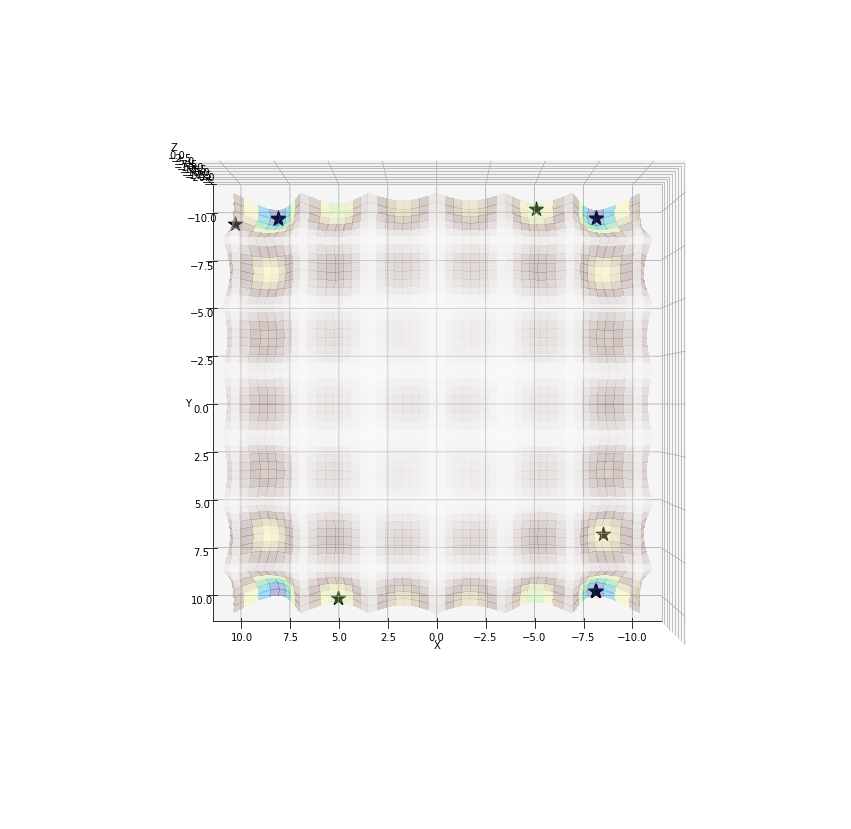

In [0]:
n = 100
limit = 10
step = 0.1
dx = 0.1
test_func = holder_table
# opt_func = partial(compose, [gtl for _ in range(n)])

opt_func = partial(compose, [gggtl for _ in range(n)])



%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-limit, limit, step)
X, Y = np.meshgrid(x, y)
Z = test_func(X, Y)
sf = ax.plot_surface(X, Y, Z, cmap='terrain', linewidth=0, antialiased=False, alpha=0.3)
# ct = ax.contour(X, Y, Z, levels=[10, 50, 100, 130], colors='black')
n = 10
for i in range(n):
  start = [random.uniform(-limit, limit), random.uniform(-limit, limit)]
  r = opt_func(test_func, [start, {}], [], [], d=limit, dx=dx, vl=[[-limit, limit], [-limit, limit]])
  ps = np.array([x[0] + list(x[1].values()) for x in r[0][3]])
  zs = np.array(r[0][2])
#   ax.scatter(ps[:1:, 0], ps[:1:, 1], zs[0], color='black', s=10**2, marker='o')
  ax.scatter(ps[-1:, 0], ps[-1:, 1], zs[-1], color='black', s=15**2, marker='*')
#   ax.scatter(ps[:, 0], ps[:, 1], zs, color='black', marker='.')
#   ax.plot(ps[:, 0], ps[:, 1], zs, color='black')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# fig.colorbar(sf, ax=ax, orientation='horizontal')
ax.view_init(90, 90)
# ax.view_init(50, -15)
# ax.view_init(-30, -30)
plt.show()